In [1]:
# Import PyTorch
import torch
from torch import nn
import torch.optim as optim

# Import torchvision 
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchsummary import summary

import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.5.1
torchvision version: 0.20.1


In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
NUM_WORKERS = os.cpu_count()
print(NUM_WORKERS)

4


In [4]:
def scan_directory(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
image_path = "C:/Users/Majid/data/Cancer"
scan_directory(image_path)

There are 3 directories and 4 images in 'C:/Users/Majid/data/Cancer'.
There are 4 directories and 0 images in 'C:/Users/Majid/data/Cancer\test'.
There are 0 directories and 120 images in 'C:/Users/Majid/data/Cancer\test\adenocarcinoma'.
There are 0 directories and 51 images in 'C:/Users/Majid/data/Cancer\test\large.cell.carcinoma'.
There are 0 directories and 54 images in 'C:/Users/Majid/data/Cancer\test\normal'.
There are 0 directories and 90 images in 'C:/Users/Majid/data/Cancer\test\squamous.cell.carcinoma'.
There are 4 directories and 0 images in 'C:/Users/Majid/data/Cancer\train'.
There are 0 directories and 195 images in 'C:/Users/Majid/data/Cancer\train\adenocarcinoma'.
There are 0 directories and 115 images in 'C:/Users/Majid/data/Cancer\train\large.cell.carcinoma'.
There are 0 directories and 148 images in 'C:/Users/Majid/data/Cancer\train\normal'.
There are 0 directories and 155 images in 'C:/Users/Majid/data/Cancer\train\squamous.cell.carcinoma'.
There are 4 directories and 

In [6]:
# Setup train and testing paths
train_dir = "C:/Users/Majid/data/Cancer/train"
test_dir = "C:/Users/Majid/data/Cancer/test"
val_dir = "C:/Users/Majid/data/Cancer/valid"

In [7]:
# A function to select a random image from a directory
def random_image_path(directory):
    image_files = [f for f in os.listdir(directory)
                    if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
    if not image_files:
        raise ValueError(f"No image files found in: {directory}")
    img_name = random.choice(image_files)
    return os.path.join(directory, img_name), img_name

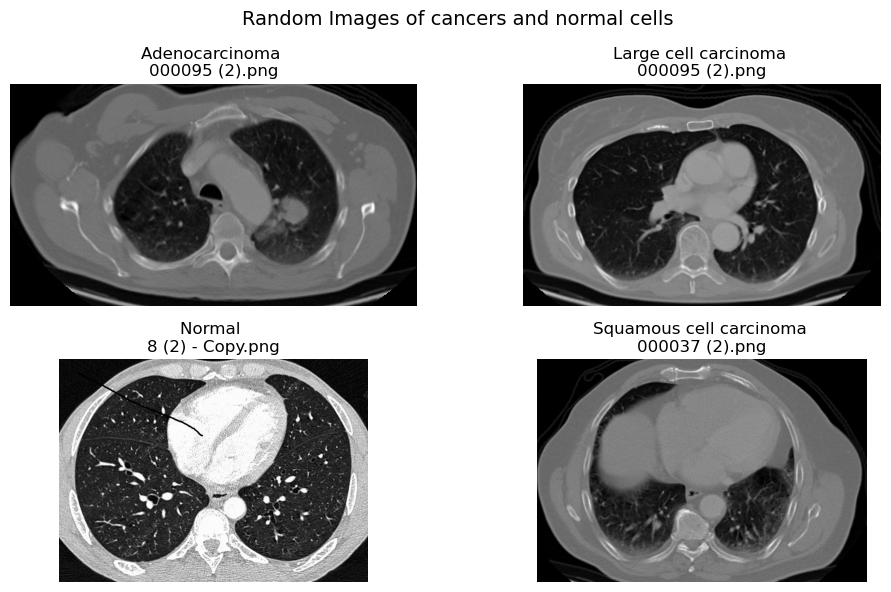

In [8]:

def plot_random_image_from_dir(dir_dog_train, dir_dog_test, dir_cat_train, dir_cat_test):
    
    # Get random images
    image_path_adenocarcinoma, random_image_adenocarcinoma = random_image_path(dir_adenocarcinoma)
    image_path_large_cell_carcinoma, random_image_large_cell_carcinoma  = random_image_path(dir_large_cell_carcinoma)
    image_path_normal, random_image_normal = random_image_path(dir_normal)
    image_path_squamous_cell_carcinoma, random_image_squamous_cell_carcinoma  = random_image_path(dir_squamous_cell_carcinoma)

    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(10, 6))
    fig.suptitle('Random Images of cancers and normal cells', fontsize=14)

    # Plot Dog Train
    image = Image.open(image_path_adenocarcinoma)
    axes[0, 0].imshow(image)
    axes[0, 0].set_title(f"Adenocarcinoma \n{random_image_large_cell_carcinoma}")
    axes[0, 0].axis('off')

    # Plot Dog Test
    image = Image.open(image_path_large_cell_carcinoma)
    axes[0, 1].imshow(image)
    axes[0, 1].set_title(f"Large cell carcinoma \n{random_image_large_cell_carcinoma}")
    axes[0, 1].axis('off')

    # Plot Cat Train
    image = Image.open(image_path_normal)
    axes[1, 0].imshow(image)
    axes[1, 0].set_title(f"Normal \n{random_image_normal}")
    axes[1, 0].axis('off')

    # Plot Cat Train
    image = Image.open(image_path_squamous_cell_carcinoma)
    axes[1, 1].imshow(image)
    axes[1, 1].set_title(f"Squamous cell carcinoma \n{random_image_squamous_cell_carcinoma}")
    axes[1, 1].axis('off')


    plt.tight_layout()
    plt.show()

# Example usage
dir_adenocarcinoma = train_dir+"/adenocarcinoma"
dir_large_cell_carcinoma = train_dir+"/large.cell.carcinoma"
dir_normal = train_dir+"/normal"
dir_squamous_cell_carcinoma = train_dir+"/squamous.cell.carcinoma"

plot_random_image_from_dir(dir_adenocarcinoma, dir_large_cell_carcinoma, dir_normal, dir_squamous_cell_carcinoma)

In [9]:
# A function to transform train and test data and augment train data
def transform_data_fn_0(image_size=128):
    # Augment data
    train_data_transform = transforms.Compose([
        # Resize the images to 128*128: our default size
        transforms.Resize(size=(image_size, image_size)),
        # (Augmenting data) - Flip the images randomly on the horizontal
        # RandomHorizontalFlip is not supported for RGBA
        # transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
        # TrivialAugmentWide is not supported for RGBA
        #transforms.TrivialAugmentWide(num_magnitude_bins=40), 
        # Turn the image into a torch.Tensor
        transforms.ToTensor(), # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
    ])
    
    # Don't augment test data
    test_data_transform = transforms.Compose([
        # Resize the image to 128*128: our default size
        transforms.Resize(size=(image_size, image_size)),
        # Turn the image into a torch.Tensor
        transforms.ToTensor(),
    ])

    # Don't augment test data
    val_data_transform = transforms.Compose([
        # Resize the image to 128*128: our default size
        transforms.Resize(size=(image_size, image_size)),
        # Turn the image into a torch.Tensor
        transforms.ToTensor(),
    ])

    return train_data_transform, test_data_transform, val_data_transform

In [10]:
train_data_transform, test_data_transform, val_data_transform = transform_data_fn_0(image_size=128)

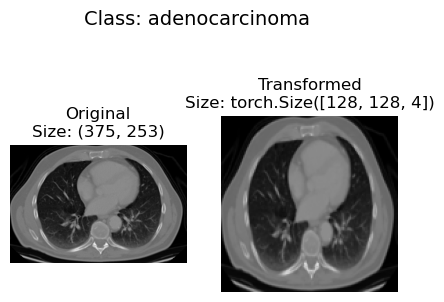

In [11]:
# Function to plot original and transformed images
def plot_transformed_image(image_path, transform):
    with Image.open(image_path) as f:
        fig, ax = plt.subplots(1, 2, figsize=(5, 4))
        
        ax[0].imshow(f)
        ax[0].set_title(f"Original\nSize: {f.size}")
        ax[0].axis("off")
        
        transformed_image = transform(f).permute(1, 2, 0)
        ax[1].imshow(transformed_image)
        ax[1].set_title(f"Transformed\nSize: {transformed_image.shape}")
        ax[1].axis("off")
        
        fig.suptitle(f"Class: {os.path.basename(os.path.dirname(image_path))}", fontsize=14)
        plt.show()

# Train data can be ugmented.
dir_adenocarcinoma = train_dir+"/adenocarcinoma"
image_path_dir_adenocarcinoma, random_image_dir_adenocarcinoma = random_image_path(dir_adenocarcinoma)
plot_transformed_image(image_path_dir_adenocarcinoma, train_data_transform)

In [12]:
"""
    As you can see this image data set has 4 channels (RGBA)
    In RGBA, the “A” stands for Alpha, which represents transparency (or opacity) of the pixel:
        R	Red	0–255	Intensity of red
        G	Green	0–255	Intensity of green
        B	Blue	0–255	Intensity of blue
        A	Alpha	0–255	Transparency, how opaque the pixel is
            A value	Meaning:
            0	Fully transparent (invisible)
            255	Fully opaque (normal pixel)
            128	50% transparent

    Because CNNs are trained on standard RGB datasets (like ImageNet), which don’t use transparency.
    When you convert: 
        img.convert("RGB")

    In almost all image classification, segmentation, or object detection tasks you should remove the Alpha (A) channel 
    Convert RGBA → RGB.
"""
    
# Remove A and convert RGBA → RGB during transformation of image:
def transform_data_fn(image_size=128):
    # Augment data
    train_data_transform = transforms.Compose([
        transforms.Lambda(lambda img: img.convert("RGB")),  # ✅ Force RGB
        # Resize the images to 128*128: our default size
        transforms.Resize(size=(image_size, image_size)),
        # (Augmenting data) - Flip the images randomly on the horizontal
        transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
        # how intense
        transforms.TrivialAugmentWide(num_magnitude_bins=40), 
        # Turn the image into a torch.Tensor
        transforms.ToTensor(), # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    
    # Don't augment test data
    test_data_transform = transforms.Compose([
        transforms.Lambda(lambda img: img.convert("RGB")),  # ✅ Force RGB
        # Resize the image to 128*128: our default size
        transforms.Resize(size=(image_size, image_size)),
        # Turn the image into a torch.Tensor
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Don't augment test data
    val_data_transform = transforms.Compose([
        transforms.Lambda(lambda img: img.convert("RGB")),  # ✅ Force RGB
        # Resize the image to 128*128: our default size
        transforms.Resize(size=(image_size, image_size)),
        # Turn the image into a torch.Tensor
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    return train_data_transform, test_data_transform, val_data_transform


In [13]:
train_data_transform, test_data_transform, val_data_transform = transform_data_fn(image_size=128)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.8208281].


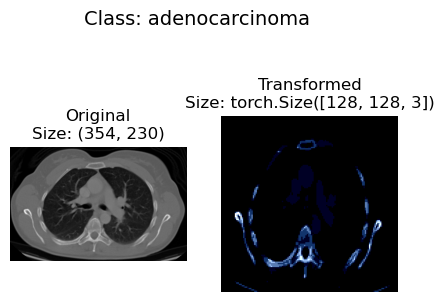

In [14]:
# Extra dimension for A is removed from dataset
dir_adenocarcinoma = train_dir+"/adenocarcinoma"
image_path_dir_adenocarcinoma, random_image_dir_adenocarcinoma = random_image_path(dir_adenocarcinoma)
plot_transformed_image(image_path_dir_adenocarcinoma, train_data_transform)

In [15]:
def load_train_test_data_fn(train_dir, test_dir, val_dir, train_data_transform, test_data_transform, val_data_transform):
    
    train_data = datasets.ImageFolder(root = train_dir,                   # target folder of images
                                     transform = train_data_transform,    # transforms to perform on data (images)
                                     target_transform = None)             # transforms to perform on labels (if necessary)

    test_data = datasets.ImageFolder(root = test_dir,
                                    transform = test_data_transform)

    val_data = datasets.ImageFolder(root = val_dir,
                                    transform = val_data_transform)
    
    return train_data, test_data, val_data

In [16]:
train_data, test_data, val_data = load_train_test_data_fn(
    train_dir = train_dir,
    test_dir = test_dir,
    val_dir = val_dir,
    train_data_transform = train_data_transform,
    test_data_transform = test_data_transform,
    val_data_transform = val_data_transform
)

print(train_data, "\n--------------------------------------------------\n")
print(test_data, "\n--------------------------------------------------\n")
print(val_data, "\n--------------------------------------------------\n")    

Dataset ImageFolder
    Number of datapoints: 613
    Root location: C:/Users/Majid/data/Cancer/train
    StandardTransform
Transform: Compose(
               Lambda()
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               TrivialAugmentWide(num_magnitude_bins=40, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ) 
--------------------------------------------------

Dataset ImageFolder
    Number of datapoints: 315
    Root location: C:/Users/Majid/data/Cancer/test
    StandardTransform
Transform: Compose(
               Lambda()
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ) 
---------------------------------

In [17]:
# Get class names as a list from train data
class_names = train_data.classes
print(class_names)

['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']


In [18]:
# Can also get class names as a dict from train data
class_dict = train_data.class_to_idx
class_dict

{'adenocarcinoma': 0,
 'large.cell.carcinoma': 1,
 'normal': 2,
 'squamous.cell.carcinoma': 3}

In [19]:
# Check the lengths
len(train_data), len(test_data), len(val_data)

(613, 315, 71)

In [20]:
"""
    Define a function to get the class names from a target directory
"""

def class_names(directory):

    # 1. Scanning the target directory to get the class names.
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. If class names not found, then Raise an error. 
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    # 3. Create a dictionary of index labels
    class_index = {class_name: i for i, class_name in enumerate(classes)}
    return classes, class_index

In [21]:
classes, classes_index = class_names(test_dir)
print(classes)
print(classes_index)

['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']
{'adenocarcinoma': 0, 'large.cell.carcinoma': 1, 'normal': 2, 'squamous.cell.carcinoma': 3}


In [22]:
"""
    Get the information of train data 0 and it's label.
"""
img, label = train_data[400][0], train_data[400][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")
print(f"Label class name: {classes[label]}")

Image tensor:
tensor([[[-2.0665, -2.0665, -2.0665,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [ 1.1529,  0.6392,  0.1083,  ..., -2.1179, -2.1179, -2.1179],
         [ 0.8789,  1.3755,  1.5639,  ..., -2.1179, -2.1179, -2.1179],
         [-1.1075, -0.8164, -0.4054,  ..., -2.1179, -2.1179, -2.1179]],

        [[-1.9832, -1.9832, -1.9832,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [ 1.3081,  0.7829,  0.2402,  ..., -2.0357, -2.0357, -2.0357],
         [ 1.0280,  1.5357,  1.7283,  ..., -2.0357, -2.0357, -2.0357],
         [-1.0203, -0.7227, -0.3025,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.7522, -1.7522, -1.7522,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.

In [23]:
"""
    Rearrange the order of dimensions
    Change from: [color_channels, height, width] --->>> to [height, width, color_channels]
"""

img_permute = img.permute(1, 2, 0)
# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

Original shape: torch.Size([3, 128, 128]) -> [color_channels, height, width]
Image permute shape: torch.Size([128, 128, 3]) -> [height, width, color_channels]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


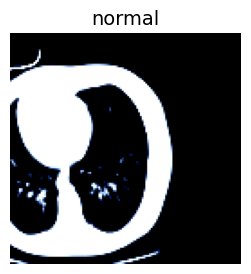

In [24]:
# Plot the image of a train train_data
# Image has less quality because image resized from 512x512 to 64x64 pixels.
plt.figure(figsize=(4, 3))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(classes[label], fontsize=14);

In [25]:
"""
    Turn loaded images into DataLoader's
    Turn dataset into dataloader by using torch.utils.data.DataLoader.
"""

# A function to create train and test data loader

def train_test_dataloader_fn(train_data, test_data, val_data, batch_size=32, num_workers=0, shuffle=True):
    train_dataloader = DataLoader(dataset = train_data,
                                 batch_size = batch_size,          # how many samples per batch?
                                 num_workers = num_workers,         # how many subprocesses to use for data loading? (higher = more)
                                 shuffle = True)          # shuffle the data?
    
    test_dataloader = DataLoader(dataset = test_data,
                                batch_size = batch_size,
                                num_workers = num_workers,
                                shuffle = False)
    
    val_dataloader = DataLoader(dataset = val_data,
                                batch_size = batch_size,
                                num_workers = num_workers,
                                shuffle = False)

    return train_dataloader, test_dataloader, val_dataloader

In [26]:
batch_size = 16
# num_workers = os.cpu_count() 

train_dataloader, test_dataloader, val_dataloader = train_test_dataloader_fn(
    train_data = train_data,
    test_data = test_data,
    val_data = val_data,
    batch_size = batch_size,
    # num_workers = num_workers,
    shuffle = True
)

print(train_dataloader,"\n", test_dataloader, "\n", val_dataloader)

In [27]:
"""
  Batch size will now be 1
  try changing the batch_size parameter above and see what happens
"""
img, label = next(iter(train_dataloader))
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([16, 3, 128, 128]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([16])


In [28]:
img_permute = img.permute(0, 2, 3, 1)
# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [batchs, color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [batchs, height, width, color_channels]")

Original shape: torch.Size([16, 3, 128, 128]) -> [batchs, color_channels, height, width]
Image permute shape: torch.Size([16, 128, 128, 3]) -> [batchs, height, width, color_channels]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


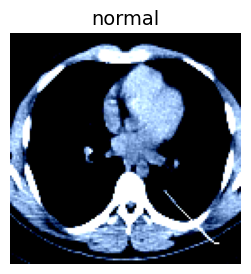

In [29]:
# Plot the image of a train train_data
# Image has less quality because image resized from 512x512 to 64x64 pixels.
plt.figure(figsize=(4, 3))
# Plot the first image of the batch
plt.imshow(img_permute[0])
plt.axis("off")
plt.title(classes[label[0]], fontsize=14);

In [30]:
# Creating transforms and loading data for Model 0

# Setup train and testing paths
train_dir = "C:/Users/Majid/data/Cancer/train"
test_dir = "C:/Users/Majid/data/Cancer/test"
val_dir = "C:/Users/Majid/data/Cancer/valid"

# Setup batch size and number of workers 
batch_size = 16
# num_workers = os.cpu_count()
image_size = 128

# 1. Create a transfomres for train data (with augmentation), and test data (without augmentation)
train_data_transform, test_data_transform, val_data_transform = transform_data_fn(image_size=image_size)

# 2. Load train and test data from the directories
train_data, test_data, val_data = load_train_test_data_fn(
    train_dir=train_dir,
    test_dir = test_dir,
    val_dir = val_dir,
    train_data_transform = train_data_transform,
    test_data_transform = test_data_transform,
    val_data_transform = val_data_transform
)

# 3. Create data loader for train and test data
train_dataloader, test_dataloader, val_dataloader = train_test_dataloader_fn(
    train_data = train_data,
    test_data = test_data,
    val_data = val_data,
    batch_size = batch_size,
    # num_workers = num_workers,
    shuffle = True
)

In [31]:
"""
    Create a baseline model: Model 0
    Is the Simplest model and is the subclass of nn.Module.
    Our baseline model consists of two nn.Linear()
    We use a nn.Flatten() layer that compresses the dimensions of a tensor into a single vector.
"""
# Create a flatten layer
flatten_model = nn.Flatten() # all nn modules function as a model (can do a forward pass)


# Get a single sample
batch_image, label_batch = next(iter(train_dataloader))
x = batch_image[0]

# Flatten the sample
output = flatten_model(x) # perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

Shape before flattening: torch.Size([3, 128, 128]) -> [color_channels, height, width]
Shape after flattening: torch.Size([3, 16384]) -> [color_channels, height*width]


In [32]:
class baseModelCancer(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int, image_size=128):
        super().__init__()
        self.ConvBlock1 = nn.Sequential(
            nn.Conv2d(input_size, hidden_size, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.Conv2d(hidden_size, hidden_size, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.ConvBlock2 = nn.Sequential(
            nn.Conv2d(hidden_size, hidden_size, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.Conv2d(hidden_size, hidden_size, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        size_flatten = int(hidden_size*(image_size/4)*(image_size/4))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=size_flatten, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=output_size),
        )

    def forward(self, x: torch.Tensor):
        x = self.ConvBlock1(x)   # print(x.shape)
        x = self.ConvBlock2(x)   # print(x.shape)
        x = self.classifier(x)     # print(x.shape)
        return x

In [33]:
torch.manual_seed(42)
output_size = len(classes)
# Pictures shape 3*128*128=49152
# Binary classification, output shape is 2
model_0 = baseModelCancer(
    input_size=3,    # Number of colors
    hidden_size=32,
    output_size=output_size,
    image_size=image_size
)
model_0.to(device)

baseModelCancer(
  (ConvBlock1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (ConvBlock2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32768, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=4, bias=True)
  )
)

In [34]:
summary(model_0, input_size=torch.Size([3,128,128]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
              ReLU-2         [-1, 32, 128, 128]               0
            Conv2d-3         [-1, 32, 128, 128]           9,248
              ReLU-4         [-1, 32, 128, 128]               0
         MaxPool2d-5           [-1, 32, 64, 64]               0
            Conv2d-6           [-1, 32, 64, 64]           9,248
              ReLU-7           [-1, 32, 64, 64]               0
            Conv2d-8           [-1, 32, 64, 64]           9,248
              ReLU-9           [-1, 32, 64, 64]               0
        MaxPool2d-10           [-1, 32, 32, 32]               0
          Flatten-11                [-1, 32768]               0
           Linear-12                   [-1, 32]       1,048,608
             ReLU-13                   [-1, 32]               0
           Linear-14                   

In [35]:
def accuracy_fn(y_true, y_pred):
    # y_pred: [batch_size, num_classes], raw logits
    # y_true: [batch_size], integer labels
    preds = torch.argmax(y_pred, dim=1)
    correct = (preds == y_true).sum().item()
    acc = correct / len(y_true) * 100
    return acc

In [36]:
def train_model_with_dataloaders(model, train_loader, test_loader, epochs=10, learning_rate = 0.0001):

    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

    # Setup loss functions and optimimizer
    criterion = nn.CrossEntropyLoss() # For multiclass classification in PyTorch
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()
        epoch_train_loss, epoch_train_acc = 0., 0.

        for train_features, train_targets in train_loader:
            
            train_predictions = model(train_features)
            train_loss = criterion(train_predictions, train_targets)
            
            # For multiclass classification - get predicted class
            train_accuracy = accuracy_fn(y_true=train_targets, y_pred=train_predictions)
    
            # Backward pass and optimization
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            epoch_train_loss += train_loss.item()
            epoch_train_acc += train_accuracy

        # Average over all batches
        epoch_train_loss /= len(train_loader)
        epoch_train_acc /= len(train_loader)

        # Evaluation phase
        model.eval()
        epoch_test_loss, epoch_test_acc = 0., 0.
        with torch.no_grad():
            for test_features, test_targets in test_loader:
                test_predictions = model(test_features)
                test_loss = criterion(test_predictions, test_targets)
           
                # For multiclass classification - get predicted class
                test_accuracy = accuracy_fn(y_true=test_targets, y_pred=test_predictions)
    
                epoch_test_loss += test_loss.item()
                epoch_test_acc += test_accuracy

        # Average over all batches
        epoch_test_loss /= len(test_loader)
        epoch_test_acc /= len(test_loader)

        # Store results
        train_losses.append(epoch_train_loss)
        test_losses.append(epoch_test_loss)
        train_accuracies.append(epoch_train_acc)
        test_accuracies.append(epoch_test_acc)

        # Print every 100 epochs
        if epoch % 1 == 0:
            print(f"Epoch [{epoch}/{epochs}] | "
                  f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.2f}% | "
                  f"Test Loss: {epoch_test_loss:.4f} | Test Acc: {epoch_test_acc:.2f}%")


    return train_losses, test_losses, train_accuracies, test_accuracies   

In [37]:
train_losses_0, test_losses_0, train_accuracies_0, test_accuracies_0 = train_model_with_dataloaders(
    model_0, 
    train_dataloader, 
    test_dataloader,
    epochs=10,
    learning_rate = 0.001
)

Epoch [0/10] | Train Loss: 1.2459 | Train Acc: 40.13% | Test Loss: 1.3398 | Test Acc: 29.83%
Epoch [1/10] | Train Loss: 1.1448 | Train Acc: 44.74% | Test Loss: 1.0216 | Test Acc: 45.91%
Epoch [2/10] | Train Loss: 1.0160 | Train Acc: 53.62% | Test Loss: 0.9788 | Test Acc: 46.14%
Epoch [3/10] | Train Loss: 0.9747 | Train Acc: 53.91% | Test Loss: 0.9958 | Test Acc: 45.37%
Epoch [4/10] | Train Loss: 0.9373 | Train Acc: 60.16% | Test Loss: 1.0012 | Test Acc: 46.76%
Epoch [5/10] | Train Loss: 0.8453 | Train Acc: 60.83% | Test Loss: 0.8864 | Test Acc: 54.01%
Epoch [6/10] | Train Loss: 0.8031 | Train Acc: 66.28% | Test Loss: 0.9656 | Test Acc: 50.82%
Epoch [7/10] | Train Loss: 0.8171 | Train Acc: 68.49% | Test Loss: 1.1210 | Test Acc: 49.18%
Epoch [8/10] | Train Loss: 0.7528 | Train Acc: 70.80% | Test Loss: 1.1553 | Test Acc: 47.87%
Epoch [9/10] | Train Loss: 0.6877 | Train Acc: 72.44% | Test Loss: 0.9281 | Test Acc: 54.01%


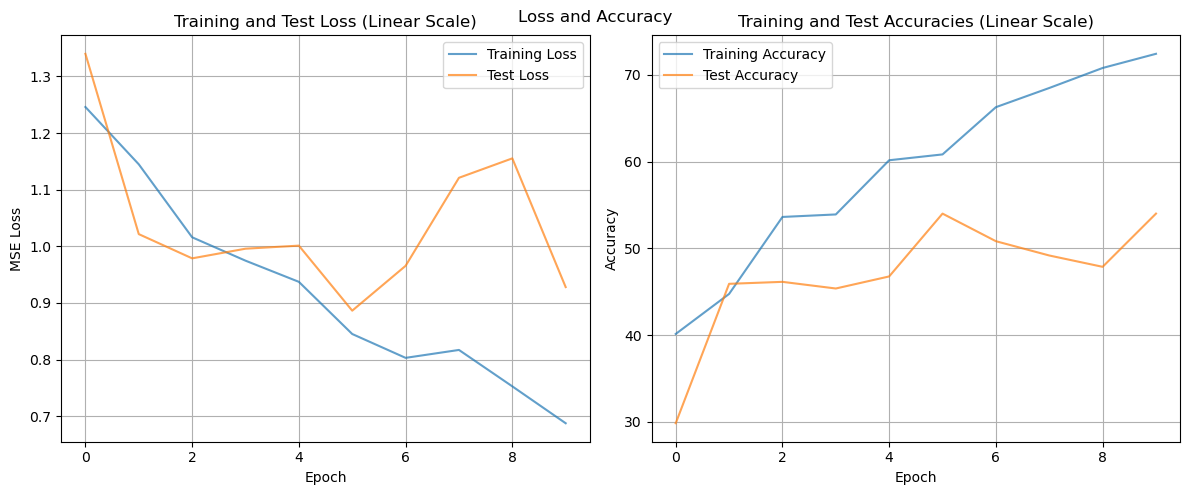

In [38]:
# Plot training and test losses

def plot_loss_accuracy(train_losses, test_losses, train_accuracies, test_accuracies, alpha=0.7):

    fig, axes = plt.subplots(1,2,figsize=(12, 5)) 

    axes[0].plot(train_losses, label='Training Loss', alpha=0.7)
    axes[0].plot(test_losses, label='Test Loss', alpha=0.7)
    axes[0].set_title("Training and Test Loss (Linear Scale)")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("MSE Loss")
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(train_accuracies, label='Training Accuracy', alpha=0.7)
    axes[1].plot(test_accuracies, label='Test Accuracy', alpha=0.7)
    axes[1].set_title("Training and Test Accuracies (Linear Scale)")
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    # Adjust spacing between subplots
    plt.tight_layout()
    
    fig.suptitle('Loss and Accuracy')

    plt.show()

plot_loss_accuracy(train_losses_0, test_losses_0, train_accuracies_0, test_accuracies_0)


In [39]:
class ImprovedModelCancer(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int, image_size=128):
        super().__init__()

        # 🔹 Block 1
        self.block1 = nn.Sequential(
            nn.Conv2d(input_size, hidden_size, kernel_size=3, padding="same"),
            nn.BatchNorm2d(hidden_size),
            nn.ReLU(),
            nn.Conv2d(hidden_size, hidden_size, kernel_size=3, padding="same"),
            nn.BatchNorm2d(hidden_size),
            nn.ReLU(),
            nn.MaxPool2d(2),          # -> 64x64
            nn.Dropout(0.25)
        )

        # 🔹 Block 2
        self.block2 = nn.Sequential(
            nn.Conv2d(hidden_size, hidden_size*2, kernel_size=3, padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(hidden_size*2, hidden_size*2, kernel_size=3, padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),          # -> 32x32
            nn.Dropout(0.25)
        )

        # 🔹 Block 3
        self.block3 = nn.Sequential(
            nn.Conv2d(hidden_size*2, hidden_size*4, kernel_size=3, padding="same"),
            nn.BatchNorm2d(hidden_size*4),
            nn.ReLU(),
            nn.Conv2d(hidden_size*4, hidden_size*4, kernel_size=3, padding="same"),
            nn.BatchNorm2d(hidden_size*4),
            nn.ReLU(),
            nn.MaxPool2d(2),          # -> 16x16
            nn.Dropout(0.25)
        )

        # 🔹 Flatten + Classifier
        # Using Adaptive pooling makes it robust to variable input sizes
        # Takes any input feature map (no matter its current spatial dimensions, say 16×16 or 7×7)
        # 128*16*16 ---> 128*4*4
        flatten_size = 128 * 4 * 4
        self.global_pool = nn.AdaptiveAvgPool2d((4, 4))  # -> output fixed 4x4

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flatten_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, output_size)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.global_pool(x)
        x = self.classifier(x)
        return x

In [40]:
torch.manual_seed(42)
output_size = len(classes)

model_1 = ImprovedModelCancer(
    input_size=3,    # Number of colors
    hidden_size=32,
    output_size=output_size,
    image_size=image_size
)
model_1.to(device)

ImprovedModelCancer(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7):

In [41]:
summary(model_1, input_size=torch.Size([3,128,128]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]           9,248
       BatchNorm2d-5         [-1, 32, 128, 128]              64
              ReLU-6         [-1, 32, 128, 128]               0
         MaxPool2d-7           [-1, 32, 64, 64]               0
           Dropout-8           [-1, 32, 64, 64]               0
            Conv2d-9           [-1, 64, 64, 64]          18,496
      BatchNorm2d-10           [-1, 64, 64, 64]             128
             ReLU-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,928
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [42]:
train_losses_1, test_losses_1, train_accuracies_1, test_accuracies_1 = train_model_with_dataloaders(
    model_1, 
    train_dataloader, 
    test_dataloader,
    epochs=10,
    learning_rate = 0.001
)

Epoch [0/10] | Train Loss: 1.4007 | Train Acc: 37.12% | Test Loss: 1.1249 | Test Acc: 35.94%
Epoch [1/10] | Train Loss: 1.2485 | Train Acc: 40.13% | Test Loss: 1.3572 | Test Acc: 21.56%
Epoch [2/10] | Train Loss: 1.0834 | Train Acc: 51.35% | Test Loss: 1.0776 | Test Acc: 51.56%
Epoch [3/10] | Train Loss: 1.0984 | Train Acc: 47.82% | Test Loss: 0.9463 | Test Acc: 53.44%
Epoch [4/10] | Train Loss: 1.0702 | Train Acc: 49.74% | Test Loss: 1.0280 | Test Acc: 55.31%
Epoch [5/10] | Train Loss: 1.0772 | Train Acc: 52.85% | Test Loss: 1.1125 | Test Acc: 45.62%
Epoch [6/10] | Train Loss: 1.0085 | Train Acc: 53.62% | Test Loss: 0.9674 | Test Acc: 51.56%
Epoch [7/10] | Train Loss: 1.0343 | Train Acc: 53.91% | Test Loss: 0.9981 | Test Acc: 53.52%
Epoch [8/10] | Train Loss: 1.0719 | Train Acc: 53.11% | Test Loss: 1.0981 | Test Acc: 41.79%
Epoch [9/10] | Train Loss: 1.0418 | Train Acc: 50.06% | Test Loss: 0.9603 | Test Acc: 56.25%


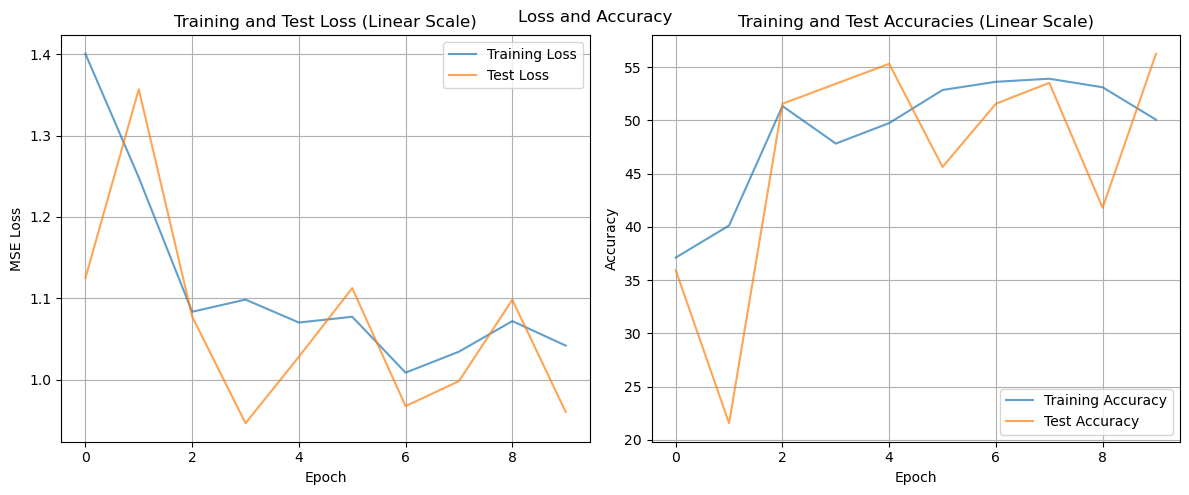

In [50]:
plot_loss_accuracy(train_losses_1, test_losses_1, train_accuracies_1, test_accuracies_1)

In [43]:
# Evaluate the model
def evaluate_model_dataloader(model, val_loader):

    # Setup loss functions and optimimizer
    criterion = nn.CrossEntropyLoss() # For multiclass classification in PyTorch

    # Evaluation phase
    model.eval()
    epoch_val_loss, epoch_val_acc = 0., 0.
    with torch.no_grad():
        for val_features, val_targets in val_loader:
            val_predictions = model(val_features)
            val_loss = criterion(val_predictions, val_targets)
           
            # For multiclass classification - get predicted class
            val_accuracy = accuracy_fn(y_true=val_targets, y_pred=val_predictions)
    
            epoch_val_loss += val_loss.item()
            epoch_val_acc += val_accuracy

        # Average over all batches
        epoch_val_loss /= len(val_loader)
        epoch_val_acc /= len(val_loader)


    return epoch_val_loss, epoch_val_acc

In [47]:
val_loss, val_accuracies = evaluate_model_dataloader(model_0, val_dataloader)
print(f"Validation loss is: {val_loss:.4f} | Validation acuuracy is: {val_accuracies:.4f}%")

Validation loss is: 0.8552 | Validation acuuracy is: 66.2500%


In [49]:
"""
    Predict the label of an aribitrary image.
"""

def predict_image(model, image_path, device, image_size):
    # Step 1: Define transforms (must match training)
    transform = transforms.Compose([
        # Resize the image to 128*128: our default size
        transforms.Resize(size=(image_size, image_size)),
        # Turn the image into a torch.Tensor
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Step 2: Open image
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)  # add batch dimension

    # Step 3: Model in eval mode
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        print(output)
        label = torch.argmax(output).item() 

    return label, classes[label]

image_path = "C:/Users/Majid/data/Cancer/adenocarcinoma.png"
image_size = 128  # Same size
device = "cuda" if torch.cuda.is_available() else "cpu"

label, prediction = predict_image(model_0, image_path, device, image_size)
print(f"Prediction: {label} and Label: {prediction}")

tensor([[ 2.0734,  2.4119, -8.0876,  1.1497]])
Prediction: 1 and Label: large.cell.carcinoma
